In [1]:
import networkx as nx
import numpy as np

from scipy.special import expit

from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.sparse as sparse


In [2]:
dpi=60

def print_graph(nodes=None, edges=None, G=None):
  if not isinstance(G, nx.Graph):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
  pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten
  options = {"node_color": "white", "edgecolors": "blue", "font_size":11, "node_size":100}
  fig, axes = plt.subplots(figsize=(10, 10), dpi=dpi)

  nx.draw(G, pos, axes, **options)
  # nx.draw_shell(G,  **options)
  plt.show()

def nodes_sorted_by_degree(graph):
  return [x[0] for x in sorted({n:graph.degree(n) for n in graph.nodes}.items(), key=lambda x:x[1], reverse=True)]

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


def graph_density(arr):
    ranksquared = arr.shape[0] ** 2
    return len(arr[arr > 0]) / ranksquared


def prune_to_density(arr, density):
    max_edge = arr.shape[0] * arr.shape[1]
    while graph_density(arr) > density:
        arr[arr == np.min(arr[arr > 0])] = 0
    return arr


def preprocess(arr, density=0.1):
    np.fill_diagonal(arr, 0)
    arr = np.maximum(arr, arr.transpose())
    if not check_symmetric(arr):
        raise Exception("Matrix not symmetric")
    print("original graph density: ", graph_density(arr))
    arr = prune_to_density(arr, density)
    print("reduced graph density: ", graph_density(arr))
    arr = np.where(arr > 0, 1, 0)
    return arr

def gen_tr_ho_networks(A_orig, alpha = 0.5, alpha_ = 0.5):
    A_ho = 1*(np.triu(A_orig,1)==1)
    rows_one, cols_one = np.where(np.triu(A_ho,1))
    ones_prob_samp = np.random.binomial(1, size=len(rows_one), p=alpha)
    A_ho[rows_one, cols_one] = ones_prob_samp
    A_ho = A_ho + A_ho.T

    A_tr = 1*(np.triu(A_ho,1)==1)
    rows_one, cols_one = np.where(np.triu(A_tr,1))
    ones_prob_samp = np.random.binomial(1, size=len(rows_one), p=alpha_)
    A_tr[rows_one, cols_one] = ones_prob_samp
    A_tr = A_tr + A_tr.T
    return A_ho, A_tr


def adj_to_nodes_edges(A):    
    num_nodes = A.shape[0]
    nodes = range(num_nodes)
    edges = np.where(np.triu(A,1))
    row = edges[0]
    col = edges[1]
    edges = np.vstack((row,col)).T
    return nodes, edges

    
def sample_true_false_edges(A_orig, A_tr, A_ho):      
    nsim_id = 0
    np.random.seed(nsim_id)
    
    A_diff = A_orig - A_ho
    e_diff = sparse.find(sparse.triu(A_diff,1)) # true candidates
    A_orig_aux = -1*A_orig + 1
    ne_orig = sparse.find(sparse.triu(A_orig_aux,1)) # false candidates
    Nsamples = 100 # number of samples
    edge_t = [] # list of true edges (positive samples)
    edge_f = [] # list of false edges (negative samples)
    for ll in range(Nsamples):
        edge_t_idx_aux = np.random.randint(len(e_diff[0]))
        edge_f_idx_aux = np.random.randint(len(ne_orig[0]))
        edge_t.append((e_diff[0][edge_t_idx_aux],e_diff[1][edge_t_idx_aux]))
        edge_f.append((ne_orig[0][edge_f_idx_aux],ne_orig[1][edge_f_idx_aux]))
    return edge_t, edge_f

def analyse_predictions(graph, preds):
    preds = [(u,v,p) for u, v, p in preds]
    true_values = np.array([graph.has_edge(u, v) for u, v, _ in preds]).astype(np.uint8)
    link_preds = np.array([expit(p) for _,_,p in preds])
    fpr, tpr, thresholds = metrics.roc_curve(true_values, link_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

## Load the data
Loading the data and visualising it.

original graph density:  0.6955681142177276
reduced graph density:  0.09994051160023795


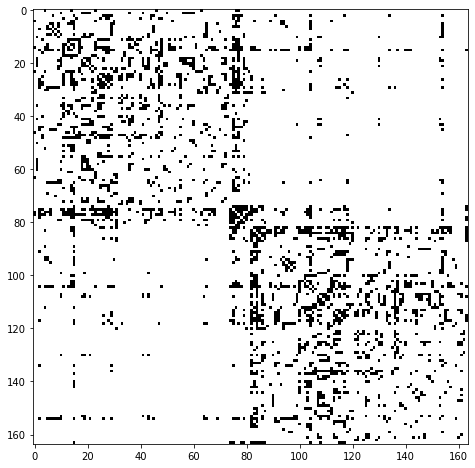

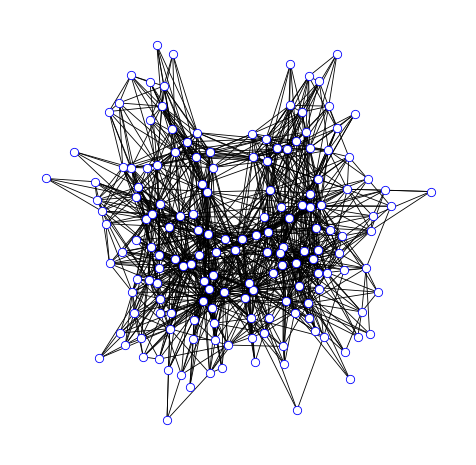

In [3]:
npzfile = np.load("HCP/data_hinne.npz")
array = npzfile["SC"][0]
array = preprocess(array, density=0.1)
graph = nx.from_numpy_matrix(array)

plt.subplots(figsize=(8, 8))
plt.imshow(array, cmap='Greys', interpolation='none')
plt.show()
print_graph(G=graph)

# Create a hold out set
Create a hold out set. (A seperate training set is also created but not used subsequently).
Furthermore sample pairs with and without edges.

In [4]:
ho, tr = gen_tr_ho_networks(array,0.8,0.8)
edge_t, edge_f = sample_true_false_edges(array, tr, ho)

## Adamic Adar Prediction

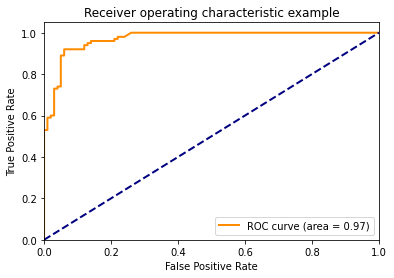

In [5]:
preds = nx.adamic_adar_index(nx.from_numpy_matrix(ho), edge_t + edge_f)
analyse_predictions(graph, preds)

## Jaccard Coefficient

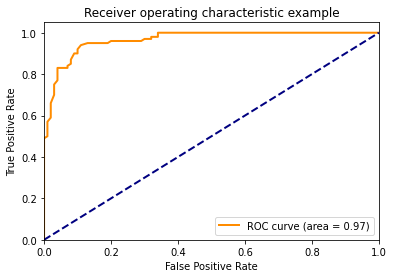

In [6]:
preds = nx.jaccard_coefficient(nx.from_numpy_matrix(ho), edge_t + edge_f)
analyse_predictions(graph, preds)

## Resource Allocation Index

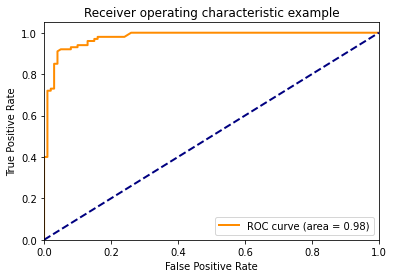

In [7]:
preds = nx.resource_allocation_index(nx.from_numpy_matrix(ho), edge_t + edge_f)
analyse_predictions(graph, preds)

## Preferential Attachment

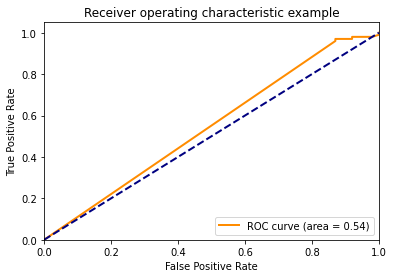

In [8]:
preds = nx.preferential_attachment(nx.from_numpy_matrix(ho), edge_t + edge_f)
analyse_predictions(graph, preds)

## Common Neighbor Centrality

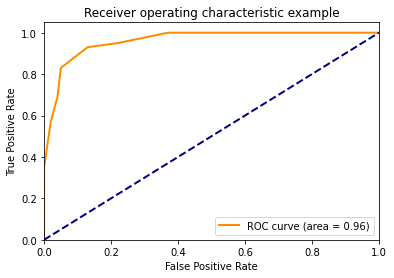

In [9]:
preds = nx.common_neighbor_centrality(nx.from_numpy_matrix(ho), edge_t + edge_f)
analyse_predictions(graph, preds)